In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import metrics
import os
import seaborn as sns
from tqdm import tqdm

try:
    from io_utils import read_jsonlines
except ModuleNotFoundError:
    import os; os.chdir("..")
    from io_utils import read_jsonlines

/zhome/ca/2/153088/memorization/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [28]:
mem_data = list(read_jsonlines("/zhome/ca/2/153088/memorization/det_outputs_v1_40000/detect_memorization_training.jsonl"))
#nonmem_data = list(read_jsonlines("/zhome/ca/2/153088/memorization/det_outputs_v1_40000/detect_memorization_validation.jsonl"))
nonmem_data = list(read_jsonlines("/zhome/ca/2/153088/memorization/det_outputs_v1_40000/detect_memorization_validation_fake_prompts.jsonl"))

Reading JSON lines from /zhome/ca/2/153088/memorization/det_outputs_v1_40000/detect_memorization_training.jsonl:   0%|          | 0/100 [00:00<?, ?lines/s]

Reading JSON lines from /zhome/ca/2/153088/memorization/det_outputs_v1_40000/detect_memorization_training.jsonl: 100%|██████████| 100/100 [00:00<00:00, 9604.76lines/s]
Reading JSON lines from /zhome/ca/2/153088/memorization/det_outputs_v1_40000/detect_memorization_validation_fake_prompts.jsonl: 100%|██████████| 50/50 [00:00<00:00, 6387.14lines/s]


In [29]:
nonmem_data[0].keys()

dict_keys(['uncond_noise_norm', 'text_noise_norm', 'prompt'])

In [30]:
# aggregation
all_data = [nonmem_data, mem_data]
nonmem_df = []
mem_df = []
new_df = [nonmem_df, mem_df]

start = 0 # the starting step to use
end = 50 # the ending step to use
num_gens = 4 # num of gens to use

for i in range(len(all_data)):
    curr_data = all_data[i]
    curr_df = new_df[i]

    # clean
    for row in tqdm(curr_data):
        new_row = {}
        for key in row.keys():
            if key == "prompt":
                continue
            
            curr_data = np.array(row[key])
            curr_data = curr_data[:num_gens, start:end]
            curr_data = np.mean(curr_data, axis=0)

            new_row[f"{key}_mean"] = np.mean(curr_data)

        curr_df.append(new_row)

all_keys = list(new_row.keys())

100%|██████████| 100/100 [00:00<00:00, 14563.56it/s]


In [31]:
mem_df = pd.DataFrame(mem_df)
mem_df["origin"] = ["Mem"]*len(mem_df)

nonmem_df = pd.DataFrame(nonmem_df)
nonmem_df["origin"] = ["Non-Mem"]*len(nonmem_df)

all_dfs = [mem_df, nonmem_df]

In [32]:
merged_df = pd.concat(all_dfs, ignore_index=True)
merged_df = merged_df.replace(0, 0.01) # for log

AUC: 0.977, ACC: 0.945, TPR@1%FPR: 0.770


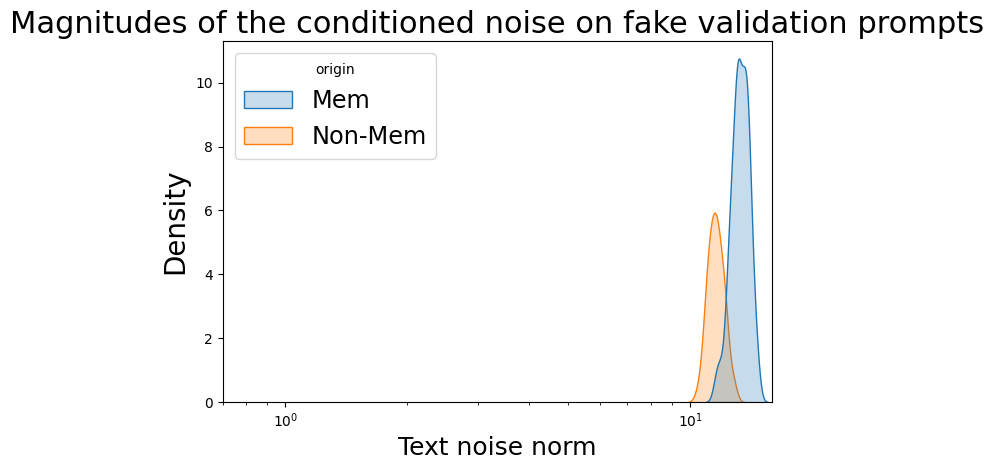

In [47]:
%matplotlib inline
preds = []
t_labels = []
for j in range(len(all_dfs)):
    curr_df = all_dfs[j]
    curr_data = curr_df["text_noise_norm_mean"].values.tolist()
    preds += curr_data
    
    if j == 0:
        t_labels += [1] * len(curr_data)
    else:
        t_labels += [0] * len(curr_data)

fpr, tpr, thresholds = metrics.roc_curve(t_labels, preds, pos_label=1)
auc = metrics.auc(fpr, tpr)
acc = np.max(1 - (fpr + (1 - tpr))/2)
low = tpr[np.where(fpr<.01)[0][-1]]

print('AUC: %.3f, ACC: %.3f, TPR@1%%FPR: %.3f' % (auc, acc, low))

ax = sns.kdeplot(data=merged_df, x="text_noise_norm_mean", hue="origin", log_scale=True, fill=True)
sns.move_legend(ax, loc="upper left", fontsize='xx-large')
ax.set_xlabel("Text noise norm", fontsize=18)  # Adjust the label and font size as needed
ax.set_ylabel("Density", fontsize=20)
plt.title("Magnitudes of the conditioned noise on fake validation prompts", fontsize=22)
plt.xlim(0.7)
plt.tight_layout()
plt.savefig("/zhome/ca/2/153088/memorization/det_outputs_v1_40000/det_mem_viz_conditioned_fake_validation.png")